In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import holidays
import pycountry
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [2]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'gpu'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

No GPU detected. Ensure your setup is correct.
CatBoost can use the GPU.


In [3]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'num_sold'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [4]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [5]:
train, test = load_dataframes(train_path,test_path)

Loading data from C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [6]:
# add the 'dataset' column to distinguish train and test data
train['dataset'] = 'train'
test['dataset'] = 'test'

# concatenate the datasets with the added 'dataset' column
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df = df.rename(columns={target_variable: 'y'})

In [7]:
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [8]:
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

In [9]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [10]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [11]:
describe_dataframe(df, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,object,0,0.000000,3652,0,328680,nan,nan,nan,nan,2010-01-01,90
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


<Figure size 1000x600 with 0 Axes>

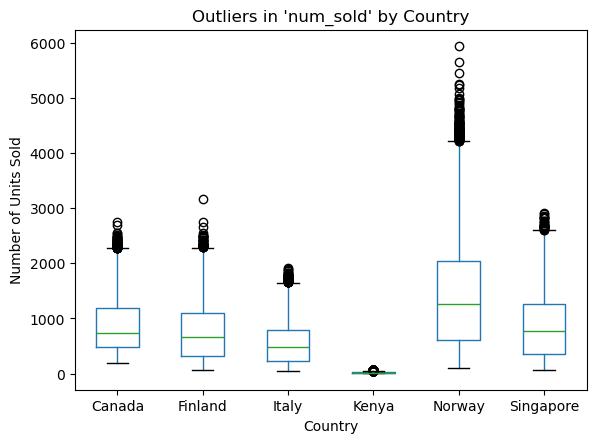

In [12]:
plt.figure(figsize=(10, 6))
df.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [13]:
# Calculate Outlier Bounds Using IQR
# Calculating Interquartile Range (IQR) to identify potential outliers
# Filtering rows where 'num_sold' is outside the lower and upper bounds

# Recalculate Q1, Q3, and IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['y'] < lower_bound) | (df['y'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 6630


In [14]:
# Group outliers by country
outliers_by_country = outliers.groupby('country').size()
print("Outliers by Country:")
print(outliers_by_country)

# Group outliers by store
outliers_by_store = outliers.groupby('store').size()
print("Outliers by Store:")
print(outliers_by_store)

# Group outliers by product
outliers_by_product = outliers.groupby('product').size()
print("Outliers by Product:")
print(outliers_by_product)

Outliers by Country:
country
Canada         11
Finland        11
Norway       6521
Singapore      87
dtype: int64
Outliers by Store:
store
Discount Stickers          1
Premium Sticker Mart    4175
Stickers for Less       2454
dtype: int64
Outliers by Product:
product
Kaggle                4169
Kaggle Tiers          2347
Kerneler                 2
Kerneler Dark Mode     112
dtype: int64


In [15]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()

    # Convert date column from object to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if 'y' in missing_numeric_columns:
        missing_numeric_columns.remove('y')
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [16]:
df = clean_dataframe(df, impute_num_nulls = True, fill_cat_nulls=False)

In [17]:
describe_dataframe(df, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,object,0,0.000000,6,0,328680,nan,nan,nan,nan,Canada,54780
3,store,object,0,0.000000,3,0,328680,nan,nan,nan,nan,Discount Stickers,109560
4,product,object,0,0.000000,5,0,328680,nan,nan,nan,nan,Holographic Goose,65736
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130


In [18]:
def get_holiday_name(country_code, date_obj):
    try:
        country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
        return country_holiday.get(date_obj)
    except Exception as e:
        print(f"Error for country code {country_code} and date {date_obj}: {e}")
        return 'Invalid Holiday'
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'     
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'

    return get_holiday_name(country_code, date_obj)


df['holiday'] = df.apply(get_holiday_for_row, axis=1)


In [20]:

df['Year'] = df['date'].dt.year
df['Quarter'] = df['date'].dt.quarter
df['Month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
#df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week

df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31.0)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31.0)
#df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.0)
#df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
df['year_sin'] = np.sin(2 * np.pi * df['Year'] / 7.0)
df['year_cos'] = np.cos(2 * np.pi * df['Year'] / 7.0)
df['Group']=(df['Year']-2010)*48+df['Month']*4+df['day_of_month']//7


df['Quarter'] = df['Quarter'].astype('str')
df['Month'] = df['Month'].astype('str')
df['day_of_week'] = df['day_of_week'].astype('str')
#df['day_of_year'] = df['day_of_year'].astype('str')
df['week_of_year'] = df['week_of_year'].astype('str')


In [22]:
RMV = ['y','dataset','id','date']
FEATURES = [c for c in df.columns if not c in RMV]

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if df[c].dtype=="object":
        CATS.append(c)
        df[c] = df[c].fillna("NAN")
        df[c],_ = df[c].factorize() # Turns cats into integers
        df[c] -= df[c].min() # Normalize to start from 0 so range is [0 : n-1]
        ftype = "categorical"
    if df[c].dtype=="int64":
        df[c] = df[c].astype("int32")
    elif df[c].dtype=="float64":
        df[c] = df[c].astype("float32")

    n = df[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )

THE 17 BASIC FEATURES ARE:
country (categorical) with 6 unique values
store (categorical) with 3 unique values
product (categorical) with 5 unique values
holiday (categorical) with 75 unique values
Year (numerical) with 10 unique values
Quarter (categorical) with 4 unique values
Month (categorical) with 12 unique values
day_of_month (numerical) with 31 unique values
day_of_week (categorical) with 7 unique values
week_of_year (categorical) with 53 unique values
day_of_month_sin (numerical) with 31 unique values
day_of_month_cos (numerical) with 16 unique values
month_sin (numerical) with 8 unique values
month_cos (numerical) with 8 unique values
year_sin (numerical) with 7 unique values
year_cos (numerical) with 4 unique values
Group (numerical) with 481 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['holiday', 'Year', 'Month', 'day_of_month', 'week_of_year', 'day_of_month_sin', 'day_of_month_cos', 'Group']


In [24]:
describe_dataframe(df, name='Sales Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,328680,0,328680,0.000000,328679.000000,164339.500000,94881.887576,nan,nan
1,date,datetime64[ns],0,0.000000,3652,0,328680,2010-01-01 00:00:00,2019-12-31 00:00:00,2014-12-31 12:00:00,nan,nan,nan
2,country,int32,0,0.000000,6,0,328680,0.000000,5.000000,2.500000,1.707828,nan,nan
3,store,int32,0,0.000000,3,0,328680,0.000000,2.000000,1.000000,0.816498,nan,nan
4,product,int32,0,0.000000,5,0,328680,0.000000,4.000000,2.000000,1.414216,nan,nan
5,y,float64,107421,32.682548,4037,0,328680,5.000000,5939.000000,752.527382,690.165445,nan,nan
6,dataset,object,0,0.000000,2,0,328680,nan,nan,nan,nan,train,230130
7,holiday,int32,0,0.000000,75,0,328680,0.000000,74.000000,4.791804,5.508516,nan,nan
8,Year,int32,0,0.000000,10,0,328680,2010.000000,2019.000000,2014.499726,2.871904,nan,nan
9,Quarter,int32,0,0.000000,4,0,328680,0.000000,3.000000,1.508762,1.117021,nan,nan


In [26]:
# replace with zero 
# Drop rows where 'dataset' is 'train' and 'num_sold' is NaN
df = df[~((df['dataset'] == 'train') & (df['y'].isna()))]

In [28]:
# Apply a logarithmic transformation to 'num_sold' to reduce skewness and stabilize variance.
# This transformation helps to handle outliers by compressing large values, making the data 
# more suitable for statistical analysis and modeling.
df['y'] = np.log(df['y'])

<Figure size 1000x600 with 0 Axes>

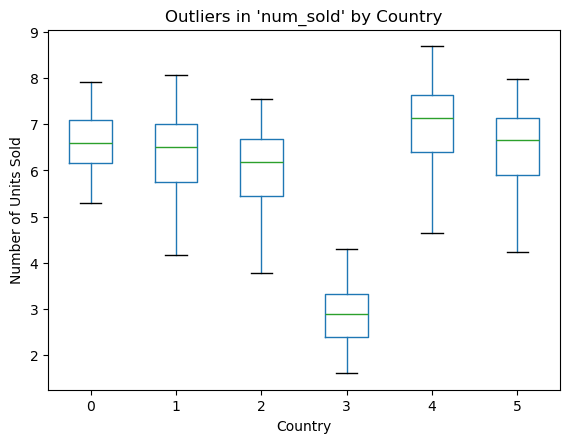

In [30]:
plt.figure(figsize=(10, 6))
df.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [32]:
# Encoding categorical variables (country, store, product) as dummy variables
# Avoiding the dummy variable trap by dropping the first category in each column

df = pd.get_dummies(df, columns=['country', 'store', 'product'], dtype=int, drop_first=True)

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='date',y='y',hue='product')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);`

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Week of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Month',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Year',y='y', hue='country')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [ ]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year Sin',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [34]:
# Splitting the training dataset into train and validation sets
# Ensuring the split preserves the time series order

# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df = df[df['dataset'] == 'test'].drop(columns=['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['y'], errors='ignore')

# Sort training data by date to preserve time series order
train_df = train_df.sort_values(by='date')

# Let's define a split date or index
train_size = int(len(train_df) * 0.86)  # 80% for training
df_train = train_df.iloc[:train_size]
df_test = train_df.iloc[train_size:]

# Separate features and target
x_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']
x_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']



# Drop the 'date' column after feature extraction
x_train = x_train.drop(columns=['date'], errors='ignore')
x_test = x_test.drop(columns=['date'], errors='ignore')

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define the objective function for Optuna, which evaluates LightGBM's performance
def objective(trial):
    # Suggest hyperparameter values to be optimized by Optuna
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),  # Maximum leaves in one tree
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),  # Learning rate for gradient boosting
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500, step=100),  # Number of boosting rounds
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples used per iteration
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features used for each tree
        "random_state": SEED,  # Ensures reproducibility
    }
    
    # Use TimeSeriesSplit to preserve temporal order during cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    model = LGBMRegressor(**params)  # Initialize the LightGBM model with current parameters
    
    errors = []  # List to store validation errors for each fold
    for train_index, val_index in tscv.split(x_train):  # Split training data for cross-validation
        x_train_cv, X_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]  # Train/validation splits
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        model.fit(x_train_cv, y_train_cv)  # Train the model on the current fold
        y_val_pred = model.predict(X_val_cv)  # Predict on the validation set
        errors.append(mean_squared_error(y_val_cv, y_val_pred))  # Calculate and store MSE
        # Calculate MAPE and store it
        
    # Calculate the Root Mean Squared Error (RMSE) for the current trial
    rmse = np.sqrt(np.mean(errors))
    return rmse  # Return RMSE as the objective value for Optuna to minimize

# Initialize an Optuna study for hyperparameter optimization
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=25)  # Optimize the objective function over 30 trials

# Print the best hyperparameters found during optimization
print("Best trial:", study.best_trial.params)

[I 2025-01-14 13:46:33,491] A new study created in memory with name: no-name-c658a582-4745-4490-ad3d-1b4ff04ce102


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:46:50,639] Trial 0 finished with value: 0.14821064812704024 and parameters: {'num_leaves': 96, 'learning_rate': 0.007124014149301609, 'n_estimators': 1100, 'subsample': 0.980188602654808, 'colsample_bytree': 0.5408719020125866}. Best is trial 0 with value: 0.14821064812704024.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:46:56,439] Trial 1 finished with value: 0.4325628784356055 and parameters: {'num_leaves': 44, 'learning_rate': 0.0032334334904052025, 'n_estimators': 600, 'subsample': 0.7423807421948436, 'colsample_bytree': 0.7324461684448393}. Best is trial 0 with value: 0.14821064812704024.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:47:05,342] Trial 2 finished with value: 0.16924849284811677 and parameters: {'num_leaves': 34, 'learning_rate': 0.0031951882940585976, 'n_estimators': 1100, 'subsample': 0.9889032504648261, 'colsample_bytree': 0.8387383425296093}. Best is trial 0 with value: 0.14821064812704024.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:47:09,389] Trial 3 finished with value: 0.11310571935497254 and parameters: {'num_leaves': 17, 'learning_rate': 0.031315458174243846, 'n_estimators': 700, 'subsample': 0.8934020662384553, 'colsample_bytree': 0.8144695706421037}. Best is trial 3 with value: 0.11310571935497254.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:47:17,899] Trial 4 finished with value: 0.11193786724983565 and parameters: {'num_leaves': 100, 'learning_rate': 0.03453697860013156, 'n_estimators': 700, 'subsample': 0.8818071914725624, 'colsample_bytree': 0.5920012046065879}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:47:39,160] Trial 5 finished with value: 0.11340284902327924 and parameters: {'num_leaves': 98, 'learning_rate': 0.004036596305651893, 'n_estimators': 1500, 'subsample': 0.807923046162252, 'colsample_bytree': 0.9081763940696508}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:47:55,960] Trial 6 finished with value: 1.2303357313085737 and parameters: {'num_leaves': 79, 'learning_rate': 0.00020613837283535436, 'n_estimators': 1300, 'subsample': 0.6179057831039834, 'colsample_bytree': 0.8429729472808949}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:18,737] Trial 7 finished with value: 1.0641438374140955 and parameters: {'num_leaves': 108, 'learning_rate': 0.00029200613305247803, 'n_estimators': 1500, 'subsample': 0.8650670866602872, 'colsample_bytree': 0.8510397511867077}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:24,646] Trial 8 finished with value: 1.453643874143518 and parameters: {'num_leaves': 31, 'learning_rate': 0.0001003638454906165, 'n_estimators': 700, 'subsample': 0.6589339897935631, 'colsample_bytree': 0.9205120310006716}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:32,232] Trial 9 finished with value: 1.209267690462303 and parameters: {'num_leaves': 102, 'learning_rate': 0.0006190657313650994, 'n_estimators': 500, 'subsample': 0.892004375156049, 'colsample_bytree': 0.7815170564912044}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:44,254] Trial 10 finished with value: 0.11394159962331452 and parameters: {'num_leaves': 127, 'learning_rate': 0.04486645521320593, 'n_estimators': 900, 'subsample': 0.5213441472327327, 'colsample_bytree': 0.590587184523214}. Best is trial 4 with value: 0.11193786724983565.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:50,982] Trial 11 finished with value: 0.11009588838737785 and parameters: {'num_leaves': 57, 'learning_rate': 0.07774668580897338, 'n_estimators': 800, 'subsample': 0.9048727697926945, 'colsample_bytree': 0.664213348185229}. Best is trial 11 with value: 0.11009588838737785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:48:57,668] Trial 12 finished with value: 0.1097312868497748 and parameters: {'num_leaves': 60, 'learning_rate': 0.09686325488457982, 'n_estimators': 900, 'subsample': 0.7942183075241707, 'colsample_bytree': 0.6702142726592866}. Best is trial 12 with value: 0.1097312868497748.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:04,467] Trial 13 finished with value: 0.11032444177530507 and parameters: {'num_leaves': 56, 'learning_rate': 0.09076764707442647, 'n_estimators': 900, 'subsample': 0.7851493839237955, 'colsample_bytree': 0.6924305480959534}. Best is trial 12 with value: 0.1097312868497748.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:14,992] Trial 14 finished with value: 0.1112897249413123 and parameters: {'num_leaves': 65, 'learning_rate': 0.01498404248103604, 'n_estimators': 900, 'subsample': 0.7140268446845919, 'colsample_bytree': 0.6539623694388736}. Best is trial 12 with value: 0.1097312868497748.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:25,001] Trial 15 finished with value: 0.11049946884872577 and parameters: {'num_leaves': 79, 'learning_rate': 0.09068799979395509, 'n_estimators': 1100, 'subsample': 0.8090254244128701, 'colsample_bytree': 0.638884921865321}. Best is trial 12 with value: 0.1097312868497748.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:33,204] Trial 16 finished with value: 1.030119752345431 and parameters: {'num_leaves': 57, 'learning_rate': 0.0010275081172100985, 'n_estimators': 800, 'subsample': 0.9419080030447864, 'colsample_bytree': 0.5129239217310781}. Best is trial 12 with value: 0.1097312868497748.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:42,786] Trial 17 finished with value: 0.10884957014656028 and parameters: {'num_leaves': 46, 'learning_rate': 0.017870092500148742, 'n_estimators': 1000, 'subsample': 0.8317508622592324, 'colsample_bytree': 0.7096640186971734}. Best is trial 17 with value: 0.10884957014656028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:49:53,748] Trial 18 finished with value: 0.1086820517548926 and parameters: {'num_leaves': 39, 'learning_rate': 0.017395446373364723, 'n_estimators': 1300, 'subsample': 0.6772742962294328, 'colsample_bytree': 0.7070807631521852}. Best is trial 18 with value: 0.1086820517548926.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:04,297] Trial 19 finished with value: 0.10967805548160049 and parameters: {'num_leaves': 43, 'learning_rate': 0.013889143278056487, 'n_estimators': 1300, 'subsample': 0.616465527090118, 'colsample_bytree': 0.98712558872677}. Best is trial 18 with value: 0.1086820517548926.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:12,954] Trial 20 finished with value: 0.11437073981788132 and parameters: {'num_leaves': 21, 'learning_rate': 0.011814315466736777, 'n_estimators': 1300, 'subsample': 0.6821570076021004, 'colsample_bytree': 0.7427357182435672}. Best is trial 18 with value: 0.1086820517548926.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:24,024] Trial 21 finished with value: 0.10920201543032368 and parameters: {'num_leaves': 44, 'learning_rate': 0.016122292316192034, 'n_estimators': 1300, 'subsample': 0.5714311810329054, 'colsample_bytree': 0.9945977623123724}. Best is trial 18 with value: 0.1086820517548926.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:35,274] Trial 22 finished with value: 0.11235711338339231 and parameters: {'num_leaves': 43, 'learning_rate': 0.008017815437187445, 'n_estimators': 1200, 'subsample': 0.5563800104879746, 'colsample_bytree': 0.9958387881306202}. Best is trial 18 with value: 0.1086820517548926.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:45,371] Trial 23 finished with value: 0.10798579096605425 and parameters: {'num_leaves': 31, 'learning_rate': 0.023830156022243615, 'n_estimators': 1400, 'subsample': 0.5747346408470733, 'colsample_bytree': 0.7079932605836127}. Best is trial 23 with value: 0.10798579096605425.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 47572, number of used features: 25
[LightGBM] [Info] Start training from score 5.934451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 95142, number of used features: 25
[LightGBM] [Info] Start training from score 5.950947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-14 13:50:55,028] Trial 24 finished with value: 0.10871076651326608 and parameters: {'num_leaves': 29, 'learning_rate': 0.02433935740975458, 'n_estimators': 1400, 'subsample': 0.6332312777709571, 'colsample_bytree': 0.7146703809897482}. Best is trial 23 with value: 0.10798579096605425.


Best trial: {'num_leaves': 31, 'learning_rate': 0.023830156022243615, 'n_estimators': 1400, 'subsample': 0.5747346408470733, 'colsample_bytree': 0.7079932605836127}


In [37]:
# Retrieve the best hyperparameters found during Optuna optimization
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model using the best hyperparameters
final_model = LGBMRegressor(**best_params)

# Train the model on the training dataset
final_model.fit(x_train, y_train)

# Predict the target variable for the test dataset
y_test_pred = final_model.predict(x_test)

# Calculate Root Mean Squared Error (RMSE) for model evaluation
# RMSE indicates the average magnitude of prediction errors, lower is better
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Final test RMSE:", final_test_rmse)

# Calculate Mean Absolute Percentage Error (MAPE) for model evaluation
# MAPE shows the average percentage error between predicted and actual values, lower is better
final_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print("Final test MAPE:", final_test_mape)

Best hyperparameters: {'num_leaves': 31, 'learning_rate': 0.023830156022243615, 'n_estimators': 1400, 'subsample': 0.5747346408470733, 'colsample_bytree': 0.7079932605836127}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 190282, number of used features: 25
[LightGBM] [Info] Start training from score 5.937273
Final test RMSE: 0.07778088950919253
Final test MAPE: 0.011931932270180707


In [ ]:
# Final test RMSE: 0.0760734597586072/
# Final test MAPE: 0.011637640001178647

In [38]:
# Separate features (X) and target variable (y) from the training data
# Dropping 'num_sold' as it's the target variable
# Dropping 'date' to avoid any unintended leakage since it is not used as a feature
X = train_df.drop(columns=['y', 'date']).copy()
y = train_df['y'].copy()

# Retrieve the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Instantiate the LightGBM model with the optimal hyperparameters
best_model = LGBMRegressor(**best_params)

# Train the model using all available training data (X, y)
best_model.fit(X, y)

Best hyperparameters: {'num_leaves': 31, 'learning_rate': 0.023830156022243615, 'n_estimators': 1400, 'subsample': 0.5747346408470733, 'colsample_bytree': 0.7079932605836127}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 221259, number of used features: 25
[LightGBM] [Info] Start training from score 5.925537


LGBMRegressor(colsample_bytree=0.7079932605836127,
              learning_rate=0.023830156022243615, n_estimators=1400,
              subsample=0.5747346408470733)

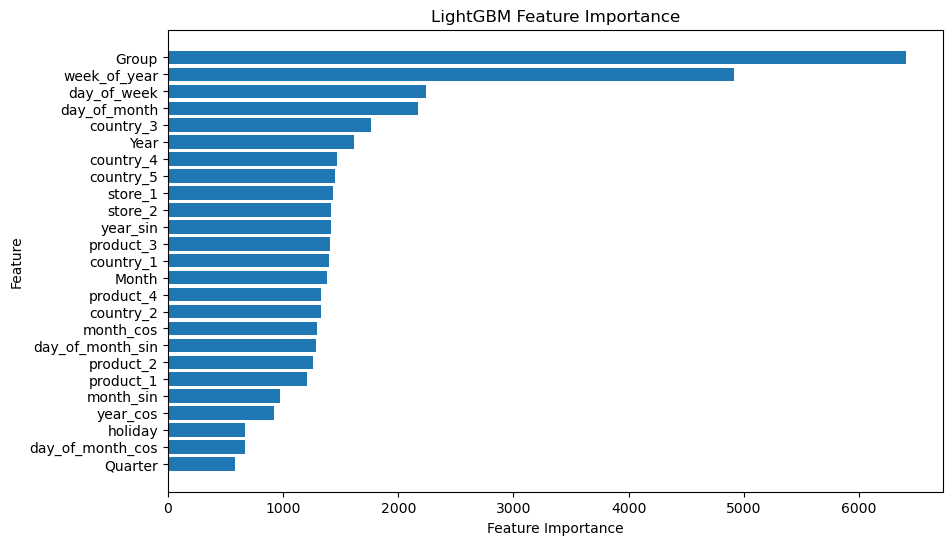

In [39]:
# Feature importance values
# importance = model.feature_importances_
importance = best_model.feature_importances_

# Feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [40]:
# Preprocess test data
test_features = test_df.drop(columns=['id', 'date'], errors='ignore')  # Drop unnecessary columns
test_features = test_features.reindex(columns=x_train.columns, fill_value=0)  # Align columns with training data

In [41]:
y_test_pred = best_model.predict(test_features)

In [42]:
sub = pd.read_csv(submission_path)
sub[target_variable] = np.expm1(y_test_pred)
sub.to_csv('Predictions_LGBM.csv', index=False)
print(sub.shape)
sub.head()

(98550, 2)


,id,num_sold
0,230130,189.391740
1,230131,953.375116
2,230132,718.746031
3,230133,386.206683
4,230134,486.845701
